In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
INPUT_DATA = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

TRAINING_SIZE = 7000
TESTING_SIZE = 2500

In [3]:
def feature_extraction(x, y, z):
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    #features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    return features

def feature_selection(X):
    data = []
    for i in range(X.shape[0]):
        features = []
        for j in range(0, X.shape[2], 3):
            x = [X[i][u][j] for u in range(X.shape[1])]
            y = [X[i][u][j+1] for u in range(X.shape[1])]
            z = [X[i][u][j+2] for u in range(X.shape[1])]
            features.append(feature_extraction(x, y, z))
        data.append(features)
        #data.append(normalize(features))
    return np.array(data)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in 
             [row.replace('  ', ' ').strip().split(' ') for row in file]
            ]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))


def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_ - 1

In [4]:

X_train_input_paths = ["data/train/" + signal + "train.txt" for signal in INPUT_DATA]
X_test_input_paths = ["data/test/" + signal + "test.txt" for signal in INPUT_DATA]
X_train = load_X(X_train_input_paths)
X_test = load_X(X_test_input_paths)

y_train_path = "data/y_train.txt"
y_test_path = "data/y_test.txt"
Y_train = load_y(y_train_path).ravel()
Y_test = load_y(y_test_path).ravel()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

#print(X_train[0])
#print(Y_train[0])

X = X_train[0:TRAINING_SIZE]
Y = Y_train[0:TRAINING_SIZE]
Xt = X_test[0:TESTING_SIZE]
Yt = Y_test[0:TESTING_SIZE]

print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Yt.shape)


X = feature_selection(X)
Xt = feature_selection(Xt)
Yhot = to_categorical(Y)

print(X.shape)
print(Xt.shape)
print(Yhot.shape)
print(X[0])

np.savetxt("data/test_data_format_raw.csv", X[0], delimiter=",")

X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
Xt = Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2])

#X = normalize(X)
#Xt = normalize(Xt)

print(X.shape)
print(Xt.shape)
print(X[0])


(7352, 128, 9)
(7352,)
(2947, 128, 9)
(2947,)
(7000, 128, 9)
(7000,)
(2500, 128, 9)
(2500,)
(7000, 3, 18)
(2500, 3, 18)
(7000, 6)
[[  2.26869062e-03  -1.65537116e-03  -8.12555104e-03   2.94102891e-03
    4.60070046e-03   1.85043626e-02   2.51075346e-03   3.61979101e-03
    1.32809971e-02   1.09814628e-05  -6.06032881e-05  -4.55357687e-04
    2.00701482e-03   2.24945950e-03   2.90326332e-03   1.43474573e-03
    1.77149521e-03   1.79056870e-03]
 [  2.22503506e-02   1.94027703e-02   9.46815498e-03   1.44340890e-02
    1.98283661e-02   5.94323827e-03   1.23813283e-02   1.64496675e-02
    4.78596706e-03  -1.08142685e-05  -5.20089234e-04  -1.91375191e-04
    4.00003418e-03   5.96561469e-03   3.71990330e-03   3.02015617e-03
    3.50187998e-03   3.47918598e-03]
 [  1.01930463e+00  -1.24261871e-01   9.97317880e-02   1.79055484e-03
    3.26999812e-03   3.96959949e-03   1.33998133e-03   2.65987287e-03
    3.00057116e-03   6.57791243e-05   1.48874333e-05  -6.25723842e-05
    2.00633937e-03   2.239

In [21]:
#Neural Network

model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], init='normal', activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=100, batch_size=64, validation_split=0.2, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))


/Users/arshanrahman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=54, activation="relu", kernel_initializer="normal")`
  after removing the cwd from sys.path.


Train on 5600 samples, validate on 1400 samples
Epoch 1/100
5600/5600 [==============================] - 0s - loss: 1.3886 - acc: 0.5500 - val_loss: 0.8624 - val_acc: 0.7486
Epoch 2/100
5600/5600 [==============================] - 0s - loss: 0.6629 - acc: 0.7268 - val_loss: 0.5366 - val_acc: 0.8407
Epoch 3/100
5600/5600 [==============================] - 0s - loss: 0.4838 - acc: 0.7943 - val_loss: 0.4566 - val_acc: 0.8679
Epoch 4/100
5600/5600 [==============================] - 0s - loss: 0.4043 - acc: 0.8370 - val_loss: 0.3945 - val_acc: 0.8907
Epoch 5/100
5600/5600 [==============================] - 0s - loss: 0.3461 - acc: 0.8596 - val_loss: 0.3495 - val_acc: 0.8993
Epoch 6/100
5600/5600 [==============================] - 0s - loss: 0.2980 - acc: 0.8812 - val_loss: 0.3273 - val_acc: 0.9014
Epoch 7/100
5600/5600 [==============================] - 0s - loss: 0.2722 - acc: 0.8861 - val_loss: 0.2992 - val_acc: 0.9071
Epoch 8/100
5600/5600 [==============================] - 0s - loss: 0.

5600/5600 [==============================] - 0s - loss: 0.1088 - acc: 0.9530 - val_loss: 0.3279 - val_acc: 0.9164
Epoch 66/100
5600/5600 [==============================] - 0s - loss: 0.1088 - acc: 0.9529 - val_loss: 0.3186 - val_acc: 0.9279
Epoch 67/100
5600/5600 [==============================] - 0s - loss: 0.1118 - acc: 0.9545 - val_loss: 0.3411 - val_acc: 0.9214
Epoch 68/100
5600/5600 [==============================] - 0s - loss: 0.1014 - acc: 0.9568 - val_loss: 0.3445 - val_acc: 0.9221
Epoch 69/100
5600/5600 [==============================] - 0s - loss: 0.1046 - acc: 0.9534 - val_loss: 0.3382 - val_acc: 0.9200
Epoch 70/100
5600/5600 [==============================] - 0s - loss: 0.1033 - acc: 0.9546 - val_loss: 0.3503 - val_acc: 0.9164
Epoch 71/100
5600/5600 [==============================] - 0s - loss: 0.1040 - acc: 0.9557 - val_loss: 0.3512 - val_acc: 0.9221
Epoch 72/100
5600/5600 [==============================] - 0s - loss: 0.1004 - acc: 0.9584 - val_loss: 0.3562 - val_acc: 0.92

[4 4 4 ..., 0 1 2]
Accuracy Rate:
0.8816
[[365   3  52   0   0   0]
 [ 21 342  24   0   0   0]
 [ 18  13 311   0   0   0]
 [  0   5   0 314 100   4]
 [  1   0   0  26 436   0]
 [  0  29   0   0   0 436]]
Precision: 88.76154217428632%
Recall: 88.16000000000001%
f1_score: 88.14341295099423%

Confusion Matrix:
[[365   3  52   0   0   0]
 [ 21 342  24   0   0   0]
 [ 18  13 311   0   0   0]
 [  0   5   0 314 100   4]
 [  1   0   0  26 436   0]
 [  0  29   0   0   0 436]]

Confusion matrix (normalised to % of total test data):
[[ 14.59999943   0.12         2.07999992   0.           0.           0.        ]
 [  0.83999997  13.68000031   0.96000004   0.           0.           0.        ]
 [  0.71999997   0.51999998  12.43999958   0.           0.           0.        ]
 [  0.           0.2          0.          12.55999947   4.           0.16      ]
 [  0.04         0.           0.           1.03999996  17.44000053   0.        ]
 [  0.           1.15999997   0.           0.           0.         

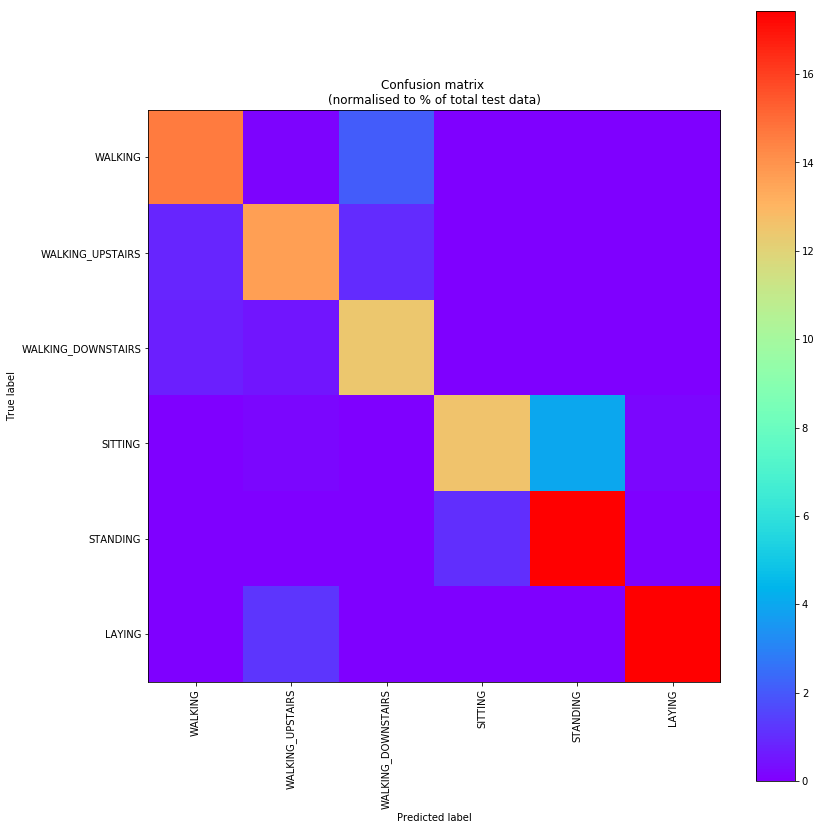

In [22]:
Y_output = model.predict(Xt)
Y_pred = np.argmax(Y_output, axis=1)
print(np.array(Y_pred))
print("Accuracy Rate:")
print(metrics.accuracy_score(Yt, Y_pred))
print(metrics.confusion_matrix(Yt, Y_pred))

print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()